In [4]:
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py

mpl.rcParams['figure.figsize'] = [10, 5]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.facecolor'] = 'white'

from tqdne.conf import Config
config = Config()
dataset_path = "/store/sdsc/sd28/wforms_GAN_input_v20220805.h5"
dataset_path

'/store/sdsc/sd28/wforms_GAN_input_v20220805.h5'

In [2]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))

with h5py.File(dataset_path, 'r', locking=False) as f:
    print("File attributes:")
    print_attrs(dataset_path, f)
    f.visititems(print_attrs)

File attributes:
/store/sdsc/sd28/wforms_GAN_input_v20220805.h5
    HP_filter_freq_lo: [1.]
    HP_filter_name: Butterworth
    HP_filter_order: [2.]
    HP_filter_type: causal
    component_order: NEZ
    creation_date: 06-Aug-2022 00:14:53
    h5Dir: /scratch/memeier/data/general/japan/bosai22/dl20220725/arx20220730/proj/wfGAN/h5/new
    hypo_dist_max: [180.]
    hypo_dist_min: [0.]
    magnitude_max: [10.]
    magnitude_min: [4.5]
    matDir: /scratch/memeier/data/general/japan/bosai22/dl20220725/arx20220730/proj/wfGAN/out
    stationList: dat/site/sitepub_all_en.txt
hypocentral_distance
hypocentre_depth
hypocentre_latitude
hypocentre_longitude
is_shallow_crustal
log10snr
magnitude
time_vector
vs30
waveforms


In [3]:
from tqdne.dataset import RepresentationDataset
from tqdne.representations import Signal


train_dataset = RepresentationDataset(config.datasetdir / config.data_train, Signal())
test_dataset = RepresentationDataset(config.datasetdir / config.data_test, Signal())

#combine train and test datasets
waveforms = np.concatenate([train_dataset.waveforms, test_dataset.waveforms])
features = np.concatenate([train_dataset.features, test_dataset.features])
waveforms.shape, features.shape 

KeyboardInterrupt: 

## Check what is the range of each feature

**NOTE**: this was before removing the negative vs30 values from the dataset

In [ ]:
for i in range(features.shape[-1]):
    print(f'Feature {config.features_keys[i]} --  min: {np.nanmin(features[:, i])}, max: {np.ma.masked_invalid(features[:, i]).max()}, max_inf: {np.max(features[:, i])}, min_inf: {np.min(features[:, i])}')

Feature hypocentral_distance --  min: 3.9779791831970215, max: 179.99957275390625, max_inf: 179.99957275390625, min_inf: 3.9779791831970215
Feature is_shallow_crustal --  min: 0.0, max: 1.0, max_inf: 1.0, min_inf: 0.0
Feature magnitude --  min: 4.5, max: 9.083505630493164, max_inf: 9.083505630493164, min_inf: 4.5
Feature vs30 --  min: -1.0, max: 2100.0, max_inf: 2100.0, min_inf: -1.0


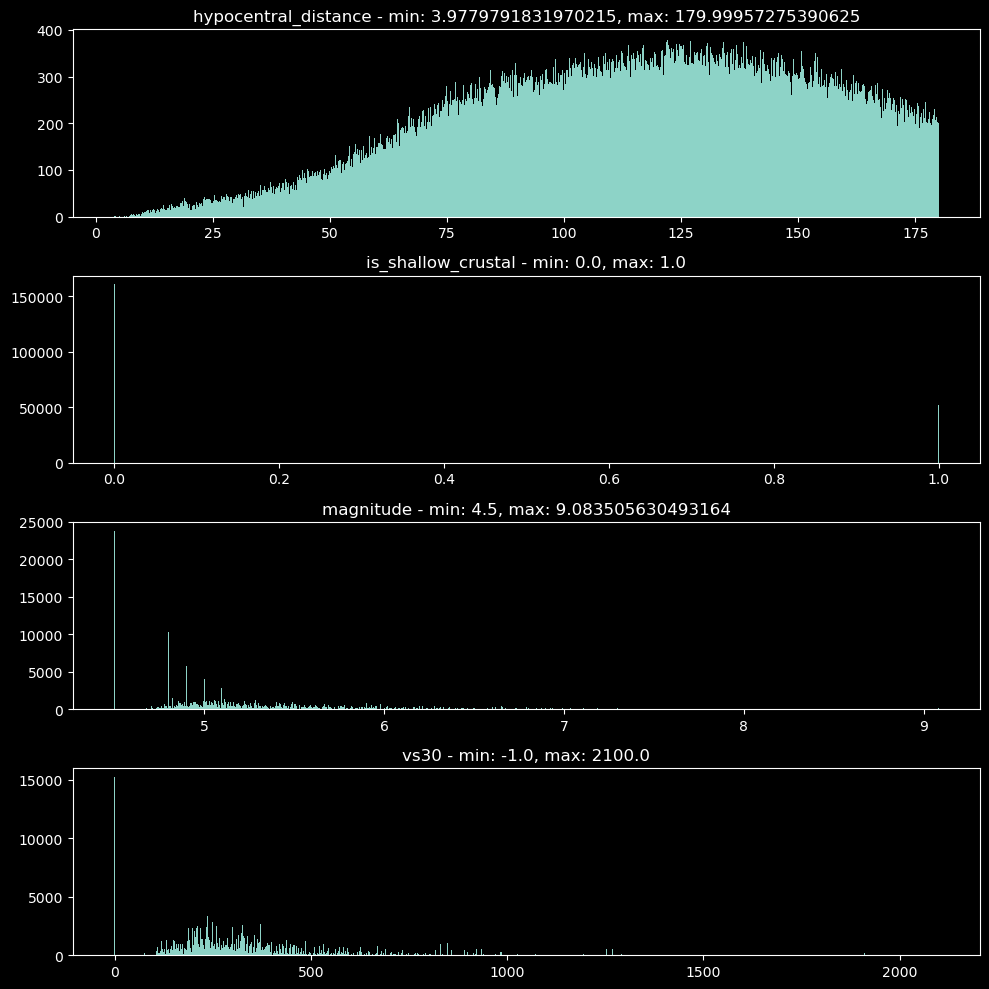

In [ ]:
# Visualize histogram for each feature
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
for i in range(features.shape[-1]):
    axs[i].hist(features[:, i], bins=1000)
    axs[i].set_title(f'{config.features_keys[i]} - min: {np.nanmin(features[:, i])}, max: {np.ma.masked_invalid(features[:, i]).max()}')
plt.tight_layout()
plt.show()

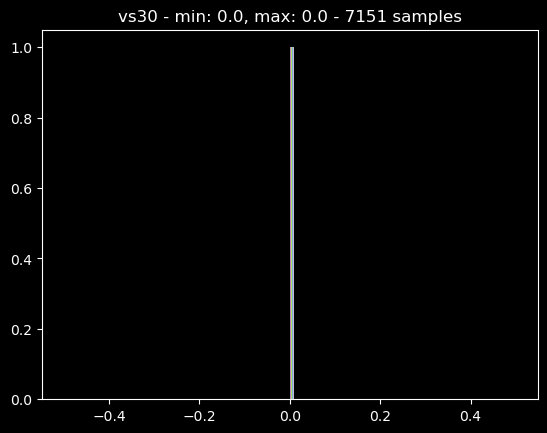

In [4]:
# Focus on VS30 feature where values are close to 0 and removing the -1 values
idxs = np.where((features[:, 3] > -0.5) & (features[:, 3] < 20))
plt.hist(features[idxs, 3], bins=100)
plt.title(f'{config.features_keys[3]} - min: {np.nanmin(features[idxs, 3])}, max: {np.ma.masked_invalid(features[idxs, 3]).max()} - {len(idxs[0])} samples')
plt.show()

In [5]:
print(f'Number of samples with VS30 < 0: {np.sum(features[:, 3] < 0)}')
print(f'Number of samples with VS30 = 0: {np.sum(features[:, 3] == 0)}')

Number of samples with VS30 < 0: 8077
Number of samples with VS30 = 0: 7151


In [3]:
# Check what if the min value when discarding -1 and 0 values
print(f'Min value of VS30 when discarding -1 and 0 values: {np.min(features[features[:, 3] > 0, 3])}')

Min value of VS30 when discarding -1 and 0 values: 76.27909851074219


## Check if there are any `nan` or `inf` values

In [5]:
np.any(np.isnan(waveforms)), np.any(np.isnan(features)), np.any(np.isinf(waveforms)), np.any(np.isinf(features))

(True, False, False, False)

In [6]:
print("Number of shallow crustal envents: ", int(np.sum(features[:, 1])))

Number of shallow crustal envents:  52076


## Visualize the effect of `hypocentral_distance` on waveforms 

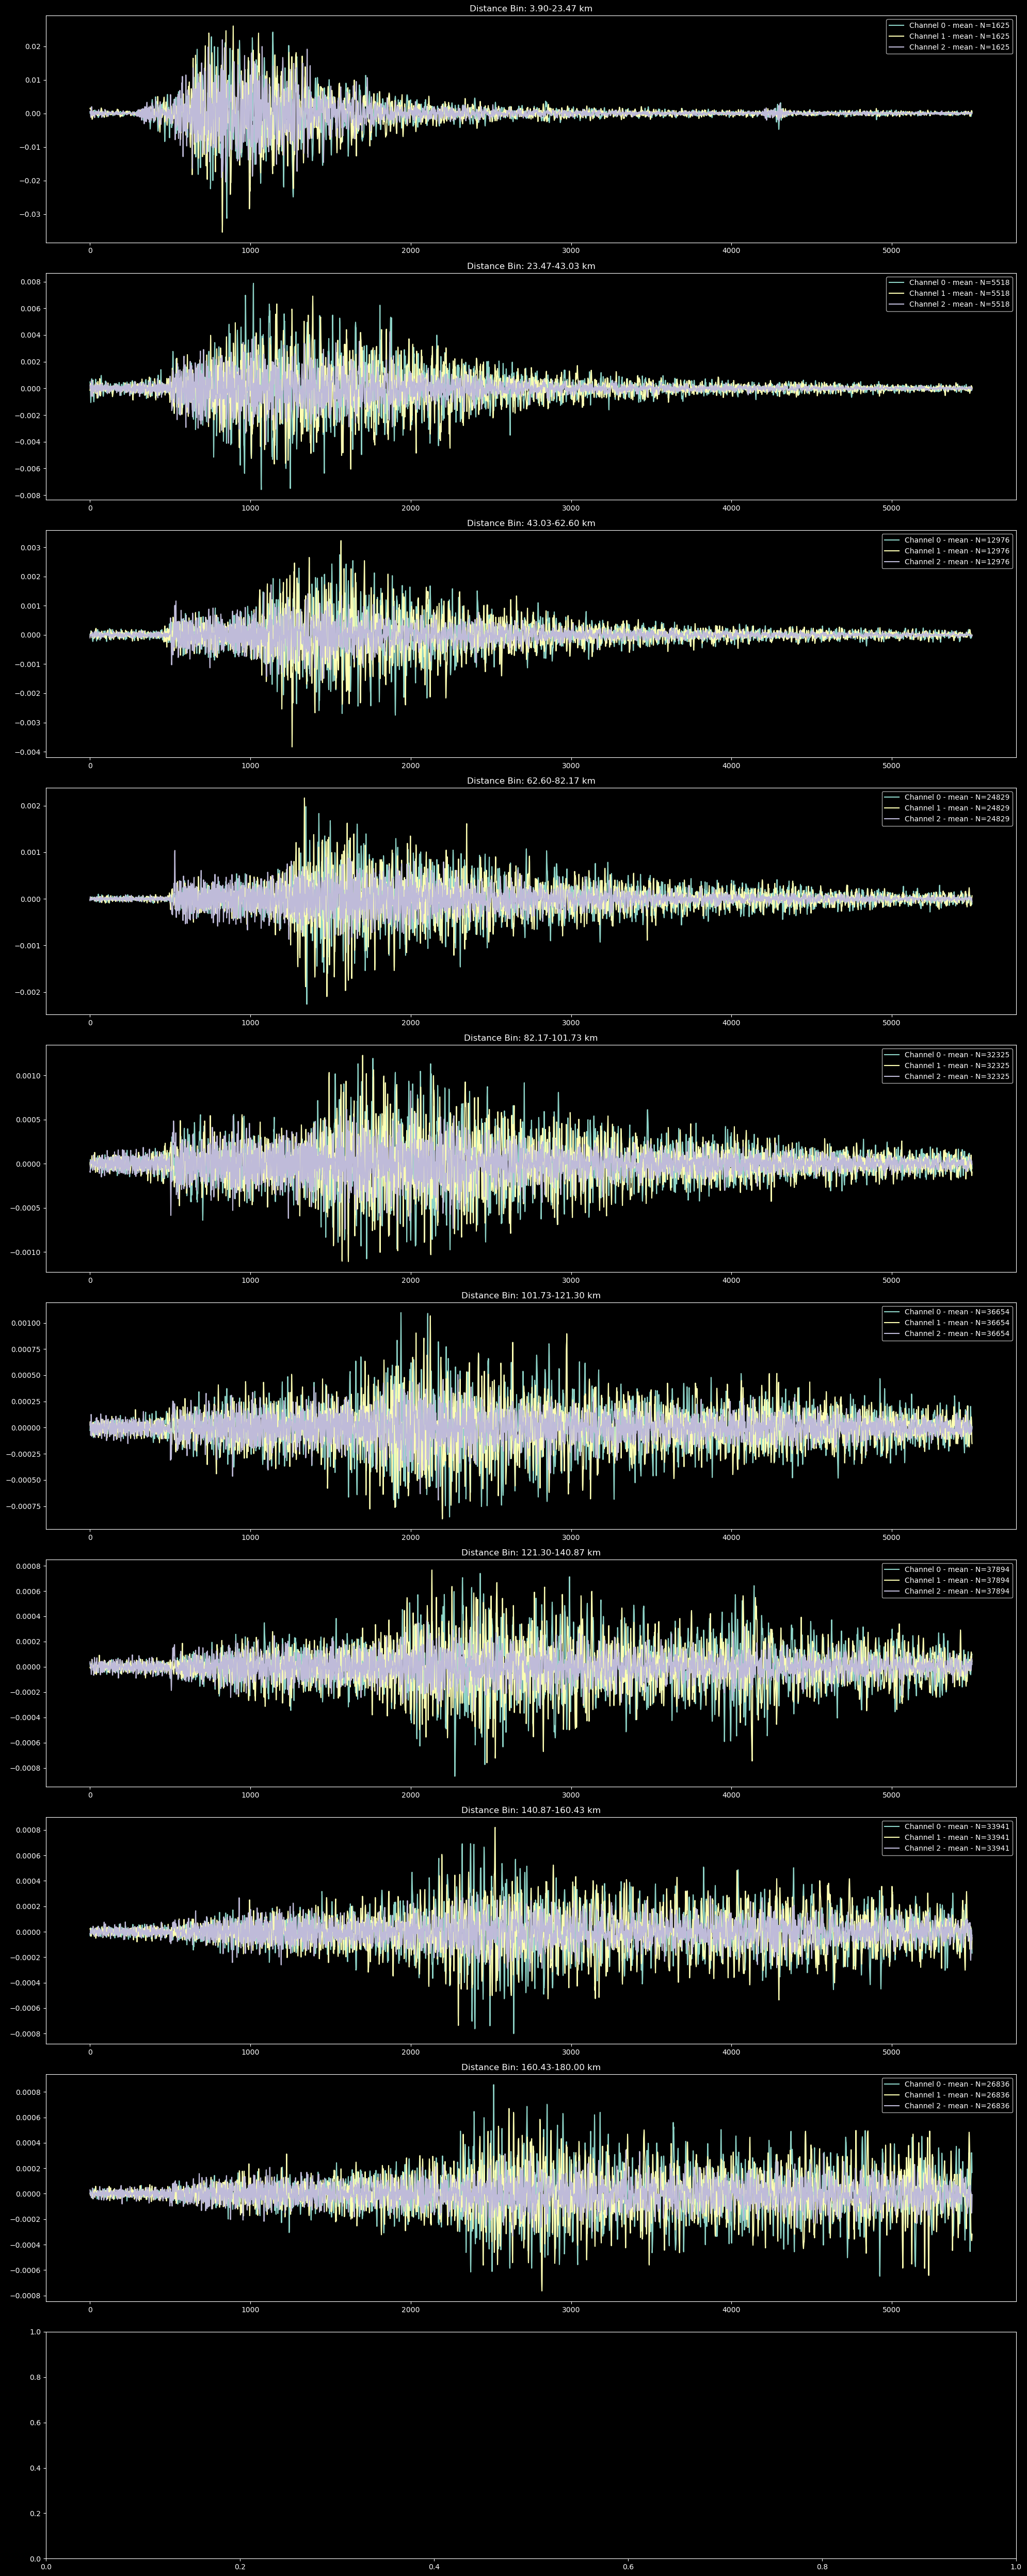

In [4]:
# define distance bins
dist_bins = np.linspace(config.conditional_params_range["hypocentral_distance"][0], config.conditional_params_range["hypocentral_distance"][1], 10)

# divide samples in dist_bins
dist_bins_samples = []
for i in range(len(dist_bins) - 1):
    mask = (features[:, 0] >= dist_bins[i]) & (features[:, 0] < dist_bins[i + 1])
    dist_bins_samples.append(np.nan_to_num((waveforms[mask])))

# plot the mean of each bin
fig, ax = plt.subplots(len(dist_bins), 1, figsize=(20, 5*len(dist_bins)))
time_ax = np.arange(0, waveforms.shape[-1]) / config.fs
for i in range(len(dist_bins_samples)):
    mean_signals = np.mean(dist_bins_samples[i], axis=0)
    for j in range(mean_signals.shape[0]):
        ax[i].plot(mean_signals[j], label=f"Channel {j} - mean - N={dist_bins_samples[i].shape[0]}")
    ax[i].legend()
    ax[i].set_title(f"Distance Bin: {dist_bins[i]:.2f}-{dist_bins[i+1]:.2f} km")
    fig.tight_layout()

Check if that's the case also by fixing the magnitude

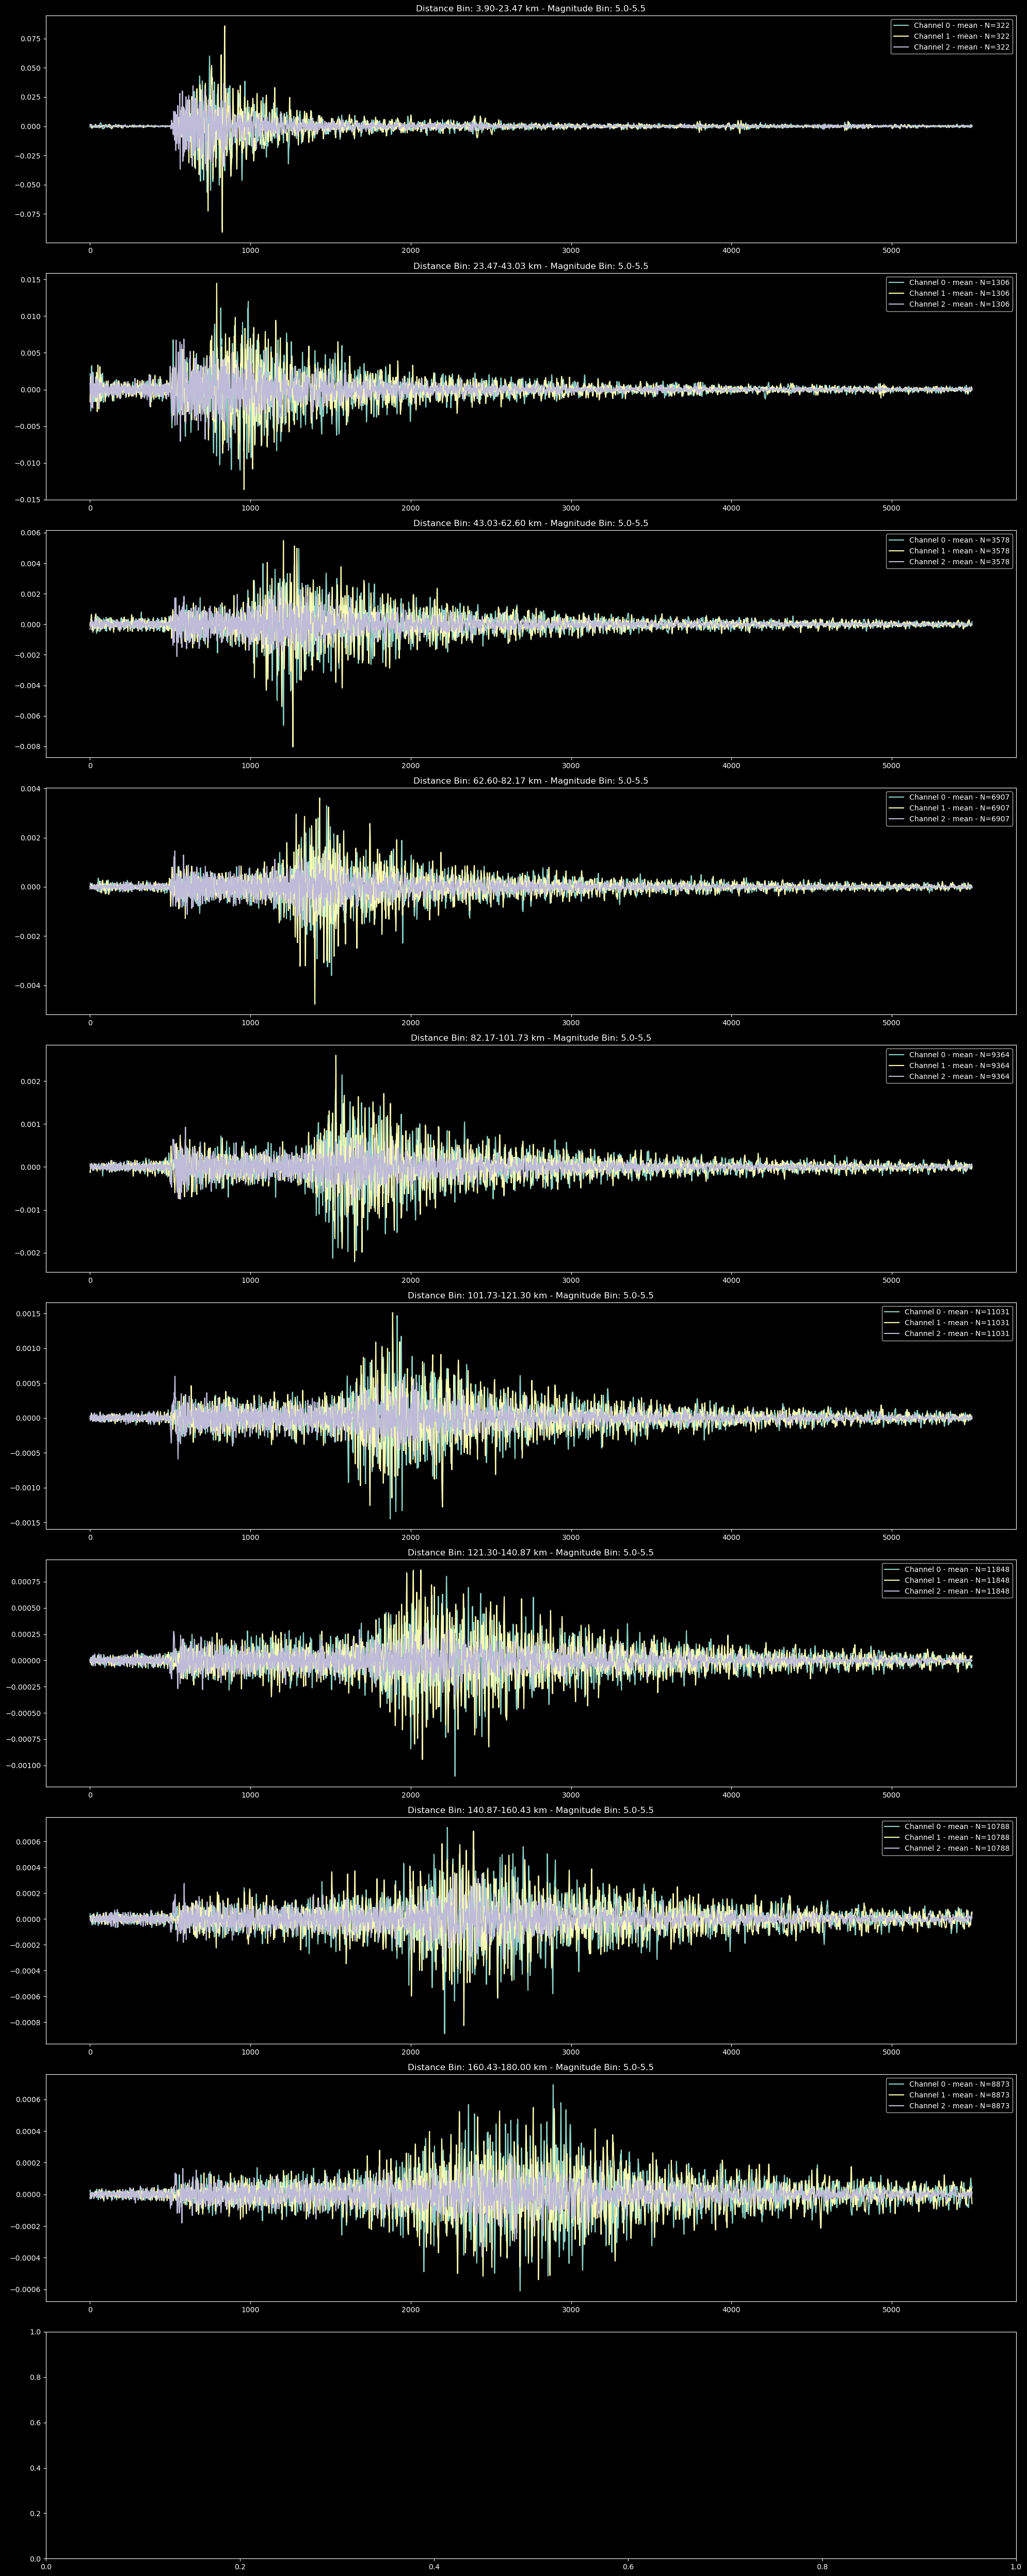

In [7]:
# define distance bins
dist_bins = np.linspace(config.conditional_params_range["hypocentral_distance"][0], config.conditional_params_range["hypocentral_distance"][1], 10)

# Fix the magnitude range
mag_bin = [5., 5.5]
mag_mask = (features[:, 2] >= mag_bin[0]) & (features[:, 2] < mag_bin[1])

# divide samples in dist_bins
dist_bins_samples = []
for i in range(len(dist_bins) - 1):
    mask = (features[:, 0] >= dist_bins[i]) & (features[:, 0] < dist_bins[i + 1]) & mag_mask
    dist_bins_samples.append(np.nan_to_num((waveforms[mask])))

# plot the mean of each bin
fig, ax = plt.subplots(len(dist_bins), 1, figsize=(20, 5*len(dist_bins)))
time_ax = np.arange(0, waveforms.shape[-1]) / config.fs
for i in range(len(dist_bins_samples)):
    mean_signals = np.mean(dist_bins_samples[i], axis=0)
    for j in range(mean_signals.shape[0]):
        ax[i].plot(mean_signals[j], label=f"Channel {j} - mean - N={dist_bins_samples[i].shape[0]}")
    ax[i].legend()
    ax[i].set_title(f"Distance Bin: {dist_bins[i]:.2f}-{dist_bins[i+1]:.2f} km - Magnitude Bin: {mag_bin[0]}-{mag_bin[1]}")
    fig.tight_layout()

## Check the median spectrum in the fequency domain of all the waveforms

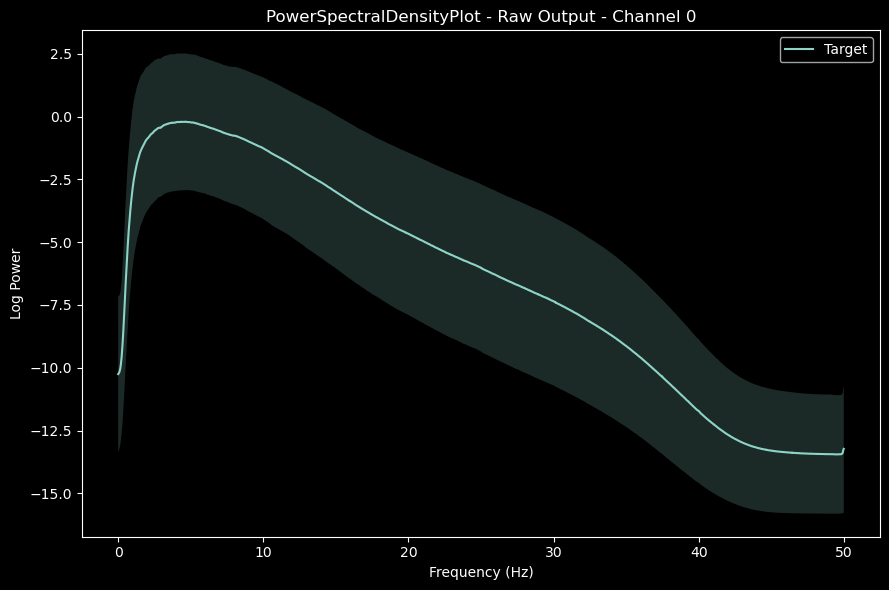

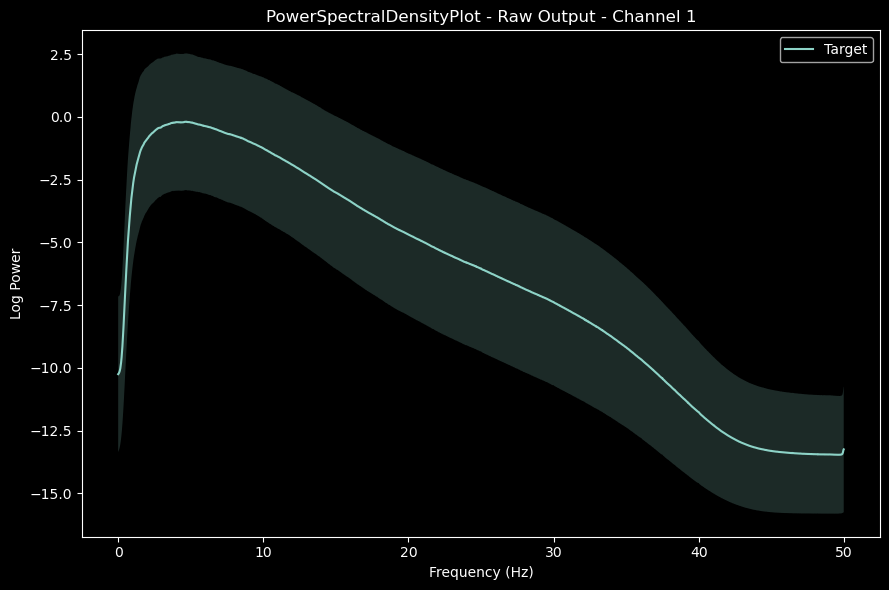

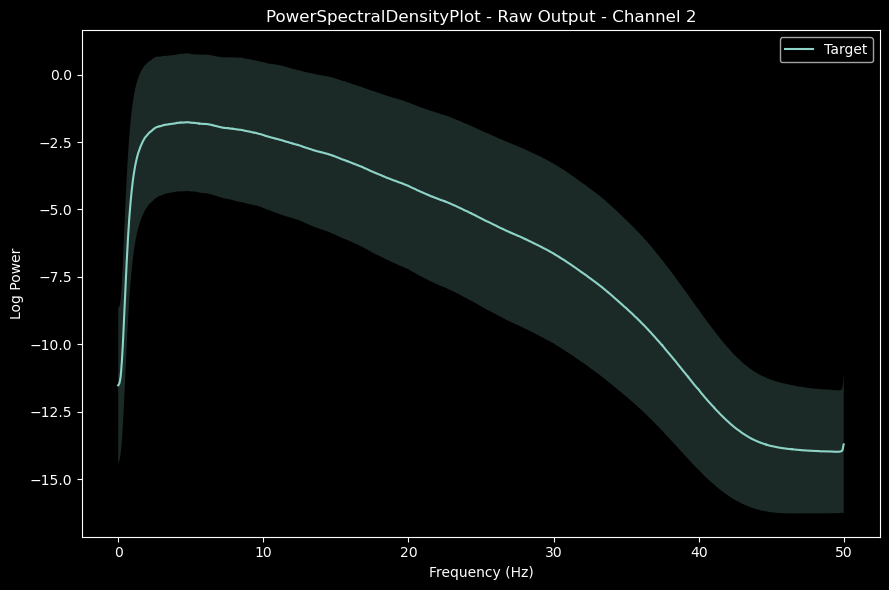

In [10]:
from tqdne.plot import PowerSpectralDensityPlot

for ch in range(3):
    psd_plot = PowerSpectralDensityPlot(channel=ch, invert_representation=False)
    psd_plot.plot(preds=None, target=waveforms[:, ch, :])

## Bin Stats

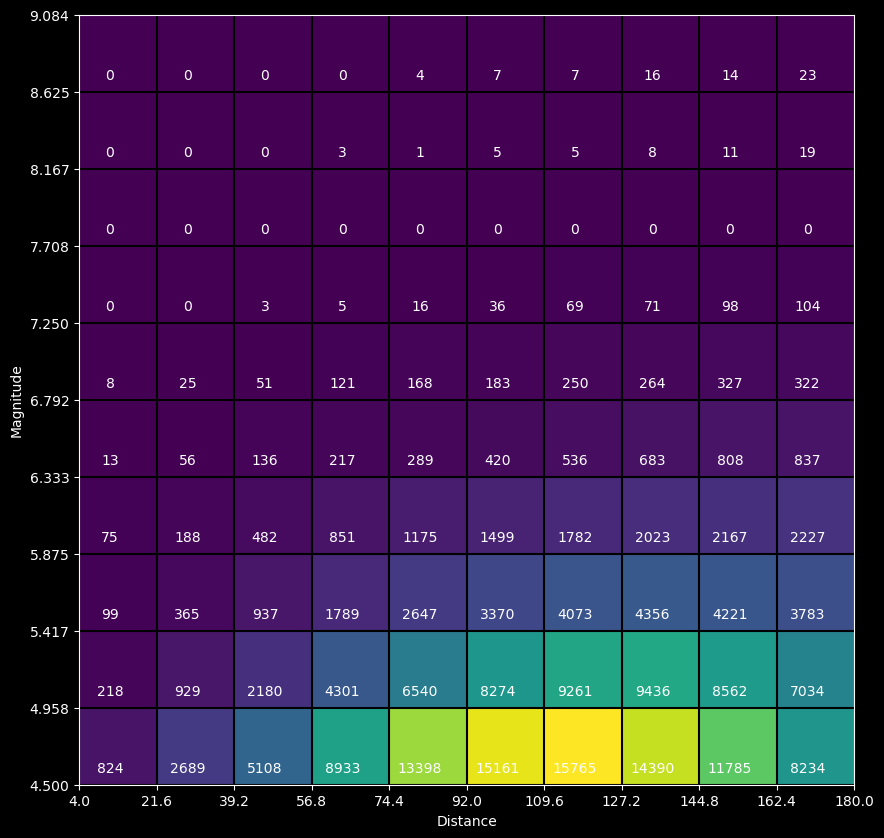

In [5]:
# 2d histogram
fig, ax = plt.subplots(1, figsize=(10, 10))
h = ax.hist2d(features[:, 0], features[:, 2], bins=10, cmap='viridis')

# set x and y ticks
ax.set_xticks(h[1])
ax.set_yticks(h[2])

ax.set_xlabel('Distance')
ax.set_ylabel('Magnitude')
for i in range(10):
    ax.axvline(h[1][i], color='black')
    ax.axhline(h[2][i], color='black')

# annotate with number of samples
for i in range(10):
    for j in range(10):
        ax.text(h[1][i]+7, h[2][j]+.1, f'{int(h[0][i, j])}', ha='center', va='center', color='white')


In [6]:
mag_bins = [(4.5, 4.8), (4.8, 5), (5, 5.5), (5.5, 6.5), (6.5, 9.1)]
dist_bins = [(0, 50), (50, 100), (100, 150), (150, 200)]

Text(0.5, 1.0, 'Number of samples in each bin - entire dataset')

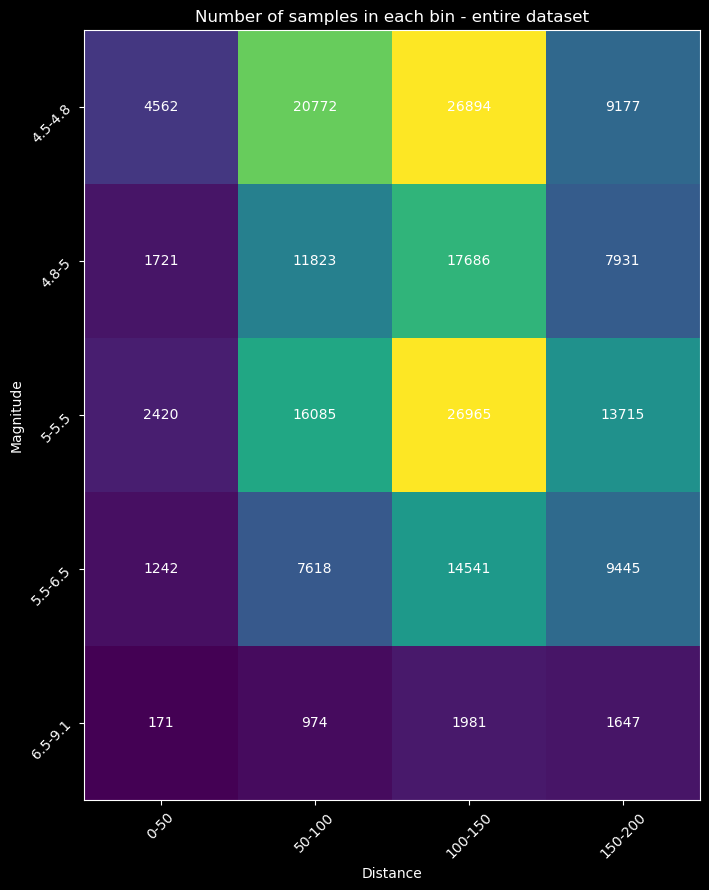

In [7]:
# find number of samples in each bin
n_samples = np.zeros((len(mag_bins), len(dist_bins)))
for i, (mag_min, mag_max) in enumerate(mag_bins):
    for j, (dist_min, dist_max) in enumerate(dist_bins):
        n_samples[i, j] = np.sum((features[:, 0] >= dist_min) & (features[:, 0] < dist_max) & (features[:, 2] >= mag_min) & (features[:, 2] < mag_max))

# plot number of samples in each bin, with annotations and with bin labels as ticks
fig, ax = plt.subplots(1, figsize=(10, 10))
h = ax.imshow(n_samples, cmap='viridis')
ax.set_xlabel('Distance')
ax.set_ylabel('Magnitude')
ax.set_xticks(np.arange(len(dist_bins)))
ax.set_xticklabels([f'{dist_min}-{dist_max}' for dist_min, dist_max in dist_bins], rotation=45)
ax.set_yticks(np.arange(len(mag_bins)))
ax.set_yticklabels([f'{mag_min}-{mag_max}' for mag_min, mag_max in mag_bins], rotation=45)
for i in range(len(mag_bins)):
    for j in range(len(dist_bins)):
        ax.text(j, i, f'{int(n_samples[i, j])}', ha='center', va='center', color='white')
ax.set_title('Number of samples in each bin - entire dataset')        



Check if the train and test distribution matches the one of the entire dataset

Text(0.5, 1.0, 'Number of samples in each bin - Train dataset')

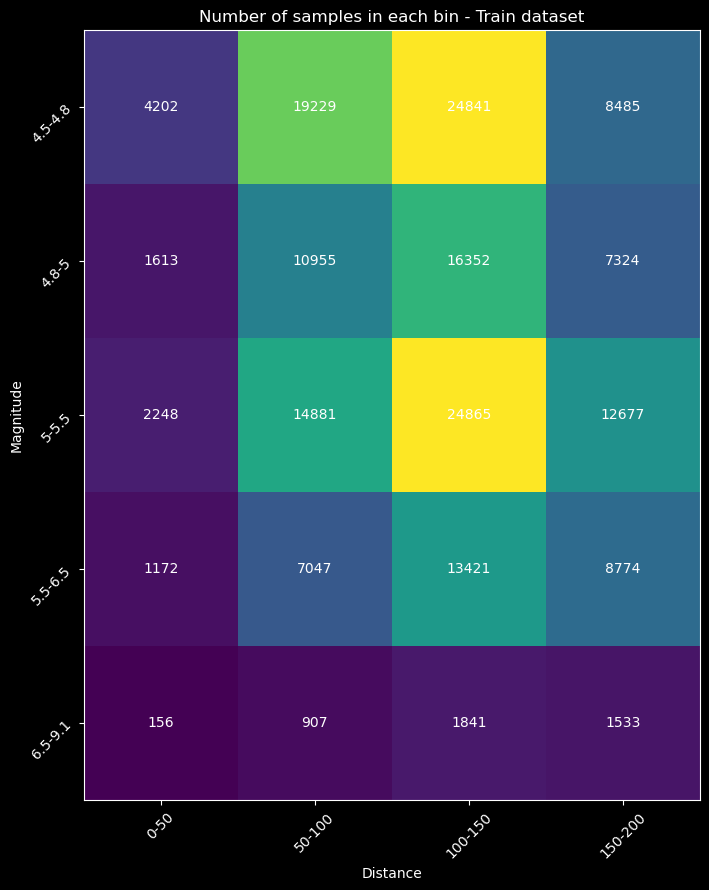

In [8]:
# find number of samples in each bin
features = train_dataset.features

n_samples = np.zeros((len(mag_bins), len(dist_bins)))
for i, (mag_min, mag_max) in enumerate(mag_bins):
    for j, (dist_min, dist_max) in enumerate(dist_bins):
        n_samples[i, j] = np.sum((features[:, 0] >= dist_min) & (features[:, 0] < dist_max) & (features[:, 2] >= mag_min) & (features[:, 2] < mag_max))

# plot number of samples in each bin, with annotations and with bin labels as ticks
fig, ax = plt.subplots(1, figsize=(10, 10))
h = ax.imshow(n_samples, cmap='viridis')
ax.set_xlabel('Distance')
ax.set_ylabel('Magnitude')
ax.set_xticks(np.arange(len(dist_bins)))
ax.set_xticklabels([f'{dist_min}-{dist_max}' for dist_min, dist_max in dist_bins], rotation=45)
ax.set_yticks(np.arange(len(mag_bins)))
ax.set_yticklabels([f'{mag_min}-{mag_max}' for mag_min, mag_max in mag_bins], rotation=45)
for i in range(len(mag_bins)):
    for j in range(len(dist_bins)):
        ax.text(j, i, f'{int(n_samples[i, j])}', ha='center', va='center', color='white')
ax.set_title('Number of samples in each bin - Train dataset')   

Text(0.5, 1.0, 'Number of samples in each bin - Test dataset')

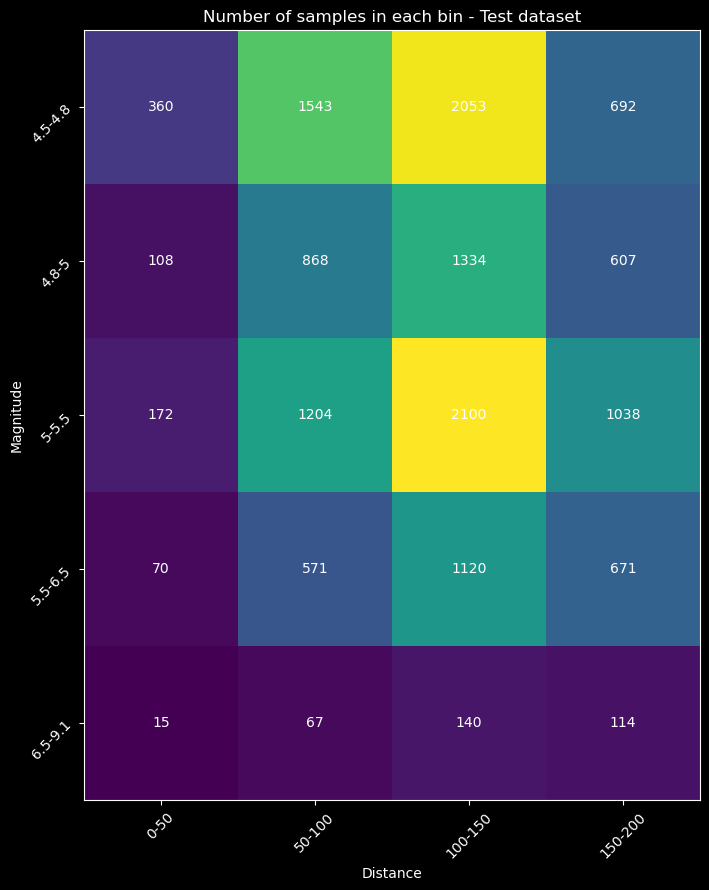

In [9]:
# find number of samples in each bin
features = test_dataset.features

n_samples = np.zeros((len(mag_bins), len(dist_bins)))
for i, (mag_min, mag_max) in enumerate(mag_bins):
    for j, (dist_min, dist_max) in enumerate(dist_bins):
        n_samples[i, j] = np.sum((features[:, 0] >= dist_min) & (features[:, 0] < dist_max) & (features[:, 2] >= mag_min) & (features[:, 2] < mag_max))

# plot number of samples in each bin, with annotations and with bin labels as ticks
fig, ax = plt.subplots(1, figsize=(10, 10))
h = ax.imshow(n_samples, cmap='viridis')
ax.set_xlabel('Distance')
ax.set_ylabel('Magnitude')
ax.set_xticks(np.arange(len(dist_bins)))
ax.set_xticklabels([f'{dist_min}-{dist_max}' for dist_min, dist_max in dist_bins], rotation=45)
ax.set_yticks(np.arange(len(mag_bins)))
ax.set_yticklabels([f'{mag_min}-{mag_max}' for mag_min, mag_max in mag_bins], rotation=45)
for i in range(len(mag_bins)):
    for j in range(len(dist_bins)):
        ax.text(j, i, f'{int(n_samples[i, j])}', ha='center', va='center', color='white')
ax.set_title('Number of samples in each bin - Test dataset')   

## Compute statistics of the training set

In [ ]:
# TODO upload only the train dataset

In [2]:
def compute_waveforms_statistics(waveforms, save_path):
    n = waveforms.shape[0]
    waveforms = np.nan_to_num(waveforms, nan=0)

    mean_signal = np.mean(waveforms, axis=0)
    std_dev_signal = np.std(waveforms, axis=0)
    max_signal = np.max(waveforms, axis=0)
    min_signal = np.min(waveforms, axis=0)

    mean = np.mean(waveforms, axis=(0,2))
    std = np.std(waveforms, axis=(0,2))
    max = np.max(waveforms, axis=(0,2))
    min = np.min(waveforms, axis=(0,2))

    num_channels = waveforms.shape[1]
    signal_statistics = {}
    for i in range(num_channels):
        signal_statistics[f'ch{i+1}'] = {'mean_signal': mean_signal[i], 'std_dev_signal': std_dev_signal[i], 'max_signal': max_signal[i], 'min_signal': min_signal[i], 'mean': mean[i], 'std_dev': std[i], 'max': max[i], 'min': min[i]}

    import pickle
    with open(save_path, 'wb') as f:
        pickle.dump(signal_statistics, f)
    
    print(f'Saved statistics to {save_path}')
    print(f'n: {n}, mean.shape: {mean.shape}, std.shape: {std.shape}, max.shape: {max.shape}, min.shape: {min.shape}, mean_signal.shape: {mean_signal.shape}, std_dev_signal.shape: {std_dev_signal.shape}, max_signal.shape: {max_signal.shape}, min_signal.shape: {min_signal.shape}')

In [3]:
from tqdne.dataset import EnvelopeDataset
from tqdne.representations import SignalWithEnvelope, Signal
from torch.utils.data import DataLoader

In [18]:
import ml_collections 
def new_dict(**kwargs):
    return ml_collections.ConfigDict(initial_dictionary=kwargs)
              
params=new_dict(
    env_function="moving_average",
    env_function_params=new_dict(
        scale=1
    ),
    env_transform="log",
    env_transform_params=new_dict(
        log_offset=1e-5
    ),
    scaling=new_dict(
        type="none"
    ),
)

train_dataset = EnvelopeDataset(config.datasetdir / config.data_train, SignalWithEnvelope(**params), cut=config.signal_length, downsample=2)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False)
waveforms = []
from tqdm import tqdm
for batch in tqdm(train_dataloader):
    waveforms.append(batch['repr'][:, :3, :].numpy(force=True))
waveforms = np.concatenate(waveforms, axis=0)
compute_waveforms_statistics(waveforms, save_path=Path("/users/abosisio/scratch/tqdne/outputs/log-env-stats_log-offset-1e-5_mov-avg-1_ds-2.pkl"))

  0%|          | 0/1536 [00:00<?, ?it/s]

100%|██████████| 1536/1536 [07:44<00:00,  3.30it/s]


Saved statistics to /users/abosisio/scratch/tqdne/outputs/log-env-stats_log-offset-1e-5_mov-avg-1_ds-2.pkl
n: 196608, mean.shape: (3,), std.shape: (3,), max.shape: (3,), min.shape: (3,), mean_signal.shape: (3, 2736), std_dev_signal.shape: (3, 2736), max_signal.shape: (3, 2736), min_signal.shape: (3, 2736)


In [21]:
import ml_collections 
def new_dict(**kwargs):
    return ml_collections.ConfigDict(initial_dictionary=kwargs)
              
params=new_dict(
    env_function="moving_average",
    env_function_params=new_dict(
        scale=3
    ),
    env_transform="log",
    env_transform_params=new_dict(
        log_offset=1e-7
    ),
    scaling=new_dict(
        type="none"
    ),
)
train_dataset = EnvelopeDataset(config.datasetdir / config.data_train, SignalWithEnvelope(**params), cut=config.signal_length, downsample=2)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False)
waveforms = []
from tqdm import tqdm
for batch in tqdm(train_dataloader):
    waveforms.append(batch['repr'][:, :3, :].numpy(force=True))
waveforms = np.concatenate(waveforms, axis=0)
compute_waveforms_statistics(waveforms, save_path=Path("/users/abosisio/scratch/tqdne/outputs/log-env-stats_log-offset-1e-7_mov-avg-3_ds-2.pkl"))

100%|██████████| 1536/1536 [08:18<00:00,  3.08it/s]


Saved statistics to /users/abosisio/scratch/tqdne/outputs/log-env-stats_log-offset-1e-7_mov-avg-3.pkl
n: 196608, mean.shape: (3,), std.shape: (3,), max.shape: (3,), min.shape: (3,), mean_signal.shape: (3, 2736), std_dev_signal.shape: (3, 2736), max_signal.shape: (3, 2736), min_signal.shape: (3, 2736)


In [4]:
import ml_collections 
def new_dict(**kwargs):
    return ml_collections.ConfigDict(initial_dictionary=kwargs)
              
params=new_dict(
    env_function="moving_average",
    env_function_params=new_dict(
        scale=2
    ),
    env_transform="log",
    env_transform_params=new_dict(
        log_offset=1e-7
    ),
    scaling=new_dict(
        type="none"
    ),
)
train_dataset = EnvelopeDataset(config.datasetdir / config.data_train, SignalWithEnvelope(**params), pad=config.signal_length, downsample=2)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False)
waveforms = []
from tqdm import tqdm
for batch in tqdm(train_dataloader):
    waveforms.append(batch['repr'][:, :3, :].numpy(force=True))
waveforms = np.concatenate(waveforms, axis=0)
compute_waveforms_statistics(waveforms, save_path=Path("/users/abosisio/scratch/tqdne/outputs/log-env-stats_log-offset-1e-7_mov-avg-2_ds-2.pkl"))

100%|██████████| 1426/1426 [07:04<00:00,  3.36it/s]


Saved statistics to /users/abosisio/scratch/tqdne/outputs/log-env-stats_log-offset-1e-7_mov-avg-2_ds-2.pkl
n: 182523, mean.shape: (3,), std.shape: (3,), max.shape: (3,), min.shape: (3,), mean_signal.shape: (3, 2751), std_dev_signal.shape: (3, 2751), max_signal.shape: (3, 2751), min_signal.shape: (3, 2751)


In [8]:
import ml_collections 
def new_dict(**kwargs):
    return ml_collections.ConfigDict(initial_dictionary=kwargs)
              
params=new_dict(
    env_function="first_order_lp",
    env_function_params=new_dict(),
    env_transform="log",
    env_transform_params=new_dict(
        log_offset=1e-5
    ),
    scaling=new_dict(
        type="none"
    ),
)
train_dataset = EnvelopeDataset(config.datasetdir / config.data_train, SignalWithEnvelope(**params), cut=config.signal_length, downsample=2)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False)
waveforms = []
from tqdm import tqdm
for batch in tqdm(train_dataloader):
    waveforms.append(batch['repr'][:, :3, :].numpy(force=True))
waveforms = np.concatenate(waveforms, axis=0)
compute_waveforms_statistics(waveforms, save_path=Path("/users/abosisio/scratch/tqdne/outputs/log-env-stats_log-offset-1e-5_first-order-lp_ds-2.pkl"))

NameError: name 'EnvelopeDataset' is not defined

In [12]:
import ml_collections 
def new_dict(**kwargs):
    return ml_collections.ConfigDict(initial_dictionary=kwargs)
              
params=new_dict(
    env_function="hilbert",
    env_function_params=new_dict(),
    env_transform="log",
    env_transform_params=new_dict(
        log_offset=1e-5
    ),
    scaling=new_dict(
        type="none"
    ),
)
train_dataset = EnvelopeDataset(config.datasetdir / config.data_train, SignalWithEnvelope(**params), cut=config.signal_length, downsample=2)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False)
waveforms = []
from tqdm import tqdm
for batch in tqdm(train_dataloader):
    waveforms.append(batch['repr'][:, :3, :].numpy(force=True))
waveforms = np.concatenate(waveforms, axis=0)
compute_waveforms_statistics(waveforms, save_path=Path("/users/abosisio/scratch/tqdne/outputs/log-env-stats_log-offset-1e-5_hilbert_ds-2.pkl"))

  0%|          | 0/1536 [00:00<?, ?it/s]

 86%|████████▌ | 1318/1536 [05:52<00:56,  3.83it/s]

In [ ]:
n = waveforms.shape[-1]
waveforms = np.nan_to_num(waveforms, nan=0)

mean_signal = np.mean(waveforms, axis=2)
std_dev_signal = np.std(waveforms, axis=2)
max_signal = np.max(waveforms, axis=2)
min_signal = np.min(waveforms, axis=2)

mean = np.mean(waveforms, axis=(1,2))
std = np.std(waveforms, axis=(1,2))
max = np.max(waveforms, axis=(1,2))
min = np.min(waveforms, axis=(1,2))

n, mean_signal.shape, std_dev_signal.shape, max_signal.shape, min_signal.shape, mean.shape, std.shape, max.shape, min.shape

(196608, (3, 5501), (3, 5501), (3, 5501), (3, 5501), (3,), (3,), (3,), (3,))

In [ ]:
num_channels = waveforms.shape[0]
signal_statistics = {}
for i in range(num_channels):
    signal_statistics[f'ch{i+1}'] = {'mean_signal': mean_signal[i], 'std_dev_signal': std_dev_signal[i], 'max_signal': max_signal[i], 'min_signal': min_signal[i], 'mean': mean[i], 'std_dev': std[i], 'max': max[i], 'min': min[i]}

signal_statistics['ch1']['mean_signal'].shape, signal_statistics['ch1']['std_dev_signal'].shape, signal_statistics['ch1']['max_signal'].shape, signal_statistics['ch1']['min_signal'].shape, signal_statistics['ch1']['mean'], signal_statistics['ch1']['std_dev'], signal_statistics['ch1']['max'], signal_statistics['ch1']['min']

((5501,),
 (5501,),
 (5501,),
 (5501,),
 3.1589977e-08,
 0.0417644,
 18.22163,
 -15.233168)

In [ ]:
import pickle

with open('signal_statistics.pkl', 'wb') as f:
    pickle.dump(signal_statistics, f)